In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import gc
from sklearn.model_selection import train_test_split
from pyarrow.parquet import ParquetFile
import pyarrow as pa 

In [2]:
pf = ParquetFile('../input/quarksgluons/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet') 
first_rows = next(pf.iter_batches(batch_size = 14000)) 
df = pa.Table.from_batches([first_rows]).to_pandas() 
del first_rows

In [3]:
df.head()

,X_jets,pt,m0,y
0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",112.411095,21.098248,0.0
1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",95.220406,14.030600,1.0
2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",97.007317,17.728968,1.0
3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",82.490311,14.702741,0.0
4,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.328483...",102.539238,19.456257,0.0


In [4]:
X1_dataset = np.array(np.array(np.array(df['X_jets'].tolist()).tolist()).tolist(), dtype='f')
X2_dataset = np.array(df['pt'], dtype='f')
X3_dataset = np.array(df['m0'], dtype='f')
y_dataset = df['y'].to_numpy().astype('f')
print(X1_dataset.shape,X2_dataset.shape,X3_dataset.shape, y_dataset.shape)
del df

(14000, 3, 125, 125) (14000,) (14000,) (14000,)


In [5]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
X2_dataset = scalar.fit_transform(X2_dataset.reshape(-1,1))
X3_dataset = scalar.fit_transform(X3_dataset.reshape(-1,1))

# X1_dataset = X1_dataset.reshape((-1,3, 125*125))
# X1_dataset[:,0,:] = scalar.fit_transform(X1_dataset[:,0,:])
# X1_dataset[:,1,:] = scalar.fit_transform(X1_dataset[:,1,:])
# X1_dataset[:,2,:] = scalar.fit_transform(X1_dataset[:,2,:])
# X1_dataset = X1_dataset.reshape((-1,3,125,125))

gc.collect()

23

In [6]:
X1_train, X1_test, X2_train, X2_test, X3_train, X3_test,y_train, y_test = train_test_split(X1_dataset,X2_dataset,X3_dataset, y_dataset, test_size = 0.2, random_state=9)
X1_train = np.moveaxis(X1_train, 1, -1)
X1_test = np.moveaxis(X1_test, 1, -1)
print(X1_train.shape, X2_train.shape, X3_train.shape, y_train.shape)
print(X1_test.shape,X2_test.shape,X3_test.shape, y_test.shape)
gc.collect()
del X1_dataset,X2_dataset,X3_dataset,y_dataset

(11200, 125, 125, 3) (11200, 1) (11200, 1) (11200,)
(2800, 125, 125, 3) (2800, 1) (2800, 1) (2800,)


In [7]:
from keras.layers import Input, Dense, Conv2D, BatchNormalization, MaxPooling2D, Flatten,concatenate
from keras.models import Model

In [8]:
# define the mixed input model
inputA = Input(shape=(125,125,3))
inputB = Input(shape=(1,))
inputC = Input(shape=(1,))

# CNN model for X_jets
x = Conv2D(4, kernel_size=(5,5), activation="relu")(inputA)
# x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(4,4))(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)

y = Dense(4, activation="relu")(inputB)
y = Dense(8, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)

z = Dense(4, activation="relu")(inputC)
z = Dense(8, activation="relu")(z)
z = Model(inputs=inputC, outputs=z)

combined = concatenate([x.output, y.output, z.output])
combined = Dense(16, activation="relu")(combined)
combined = Dense(1, activation="sigmoid")(combined)

model = Model(inputs=[x.input, y.input, z.input], outputs=combined )

2022-03-27 08:57:37.443842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 08:57:37.520684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 08:57:37.521350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 08:57:37.522824: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 121, 121, 4)  304         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 30, 30, 4)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [10]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-4,
    decay_steps=4000,
    decay_rate=0.9)
opt_func = keras.optimizers.Adam(learning_rate=lr_schedule)
# opt_func = keras.optimizers.SGD(lr=1e-4, momentum=0.9)

checkpoint_filepath = 'saved_model'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_binary_accuracy',
    save_weights_only=True,
    save_best_only=True)

model.compile(loss='binary_crossentropy',
              optimizer=opt_func,
              metrics=[
                keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=float, threshold=0.5),
                keras.metrics.AUC(name="auc", from_logits=True),
              ],
             )

history = model.fit(
          [X1_train, X2_train, X3_train],
          y_train,
          epochs=15,
          validation_split=0.1,
          batch_size=32,
          shuffle=False,
          callbacks=[checkpoint_callback])
gc.collect()

2022-03-27 08:57:40.911822: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1890000000 exceeds 10% of free system memory.
2022-03-27 08:57:43.648337: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1890000000 exceeds 10% of free system memory.
2022-03-27 08:57:45.238106: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-03-27 08:57:47.975430: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


315/315 [==============================] - 11s 12ms/step - loss: 0.6499 - binary_accuracy: 0.6447 - auc: 0.6863 - val_loss: 0.6225 - val_binary_accuracy: 0.6571 - val_auc: 0.7268
Epoch 2/15
315/315 [==============================] - 2s 7ms/step - loss: 0.6039 - binary_accuracy: 0.6886 - auc: 0.7474 - val_loss: 0.6054 - val_binary_accuracy: 0.6866 - val_auc: 0.7488
Epoch 3/15
315/315 [==============================] - 2s 7ms/step - loss: 0.5754 - binary_accuracy: 0.7111 - auc: 0.7773 - val_loss: 0.5948 - val_binary_accuracy: 0.6973 - val_auc: 0.7627
Epoch 4/15
315/315 [==============================] - 2s 7ms/step - loss: 0.5545 - binary_accuracy: 0.7270 - auc: 0.7971 - val_loss: 0.5889 - val_binary_accuracy: 0.7054 - val_auc: 0.7672
Epoch 5/15
315/315 [==============================] - 2s 7ms/step - loss: 0.5374 - binary_accuracy: 0.7388 - auc: 0.8118 - val_loss: 0.5877 - val_binary_accuracy: 0.7089 - val_auc: 0.7657
Epoch 6/15
315/315 [==============================] - 3s 8ms/step - l

1815

In [11]:
model.load_weights(checkpoint_filepath)
_, accuracy, auc = model.evaluate([X1_test, X2_test, X3_test], y_test)
print(f"Test accuracy: {accuracy}")
print(f"Test AUC: {auc}")

2022-03-27 08:59:08.813019: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 525000000 exceeds 10% of free system memory.
2022-03-27 08:59:09.405324: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 525000000 exceeds 10% of free system memory.


88/88 [==============================] - 1s 6ms/step - loss: 0.5939 - binary_accuracy: 0.7021 - auc: 0.7610
Test accuracy: 0.7021428346633911
Test AUC: 0.7609877586364746


dict_keys(['loss', 'binary_accuracy', 'auc', 'val_loss', 'val_binary_accuracy', 'val_auc'])


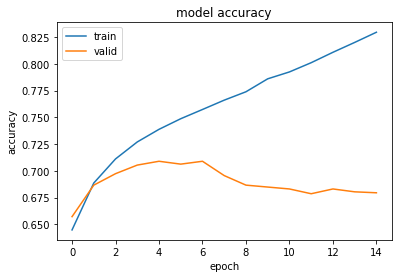

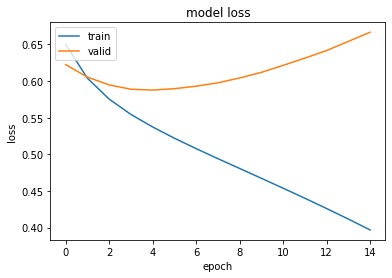

In [12]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()